In [1]:
# =========================
# Setup
# =========================
from pathlib import Path
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 80)

ROOT = Path("..")
DATA = ROOT / "data"

# Inputs
FEAT_PATH   = DATA / "processed" / "features" / "daily_features.parquet"
PANEL_PATH  = DATA / "processed" / "compare" / "daily_panel.parquet"   # detailed panel (with fee tiers)
PANEL_AGG   = DATA / "processed" / "compare" / "daily_panel_agg.parquet"

# Outputs
TAB_DIR = ROOT / "reports" / "tables" / "robustness"
FIG_DIR = ROOT / "reports" / "figures" / "robustness"
MOD_DIR = ROOT / "reports" / "models" / "robustness"
for d in [TAB_DIR, FIG_DIR, MOD_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# Events
EVENT_V3_LAUNCH = dt.date(2021, 5, 5)
EVENT_FTX       = dt.date(2022, 11, 10)

# Matplotlib defaults
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

def savefig(name: str, exts=("png","svg")):
    fig = plt.gcf()
    fig.tight_layout()
    for ext in exts:
        fig.savefig(FIG_DIR / f"{name}.{ext}", dpi=150 if ext.lower()=="png" else None, bbox_inches="tight")


print(f"[load] features: {FEAT_PATH.exists()} | panel: {PANEL_PATH.exists()} | panel_agg: {PANEL_AGG.exists()}")
df = pd.read_parquet(FEAT_PATH)
print(f"[features] rows={len(df):,}  dates={df['date'].min()}→{df['date'].max()}  labels={df['label'].nunique()}")

[load] features: True | panel: True | panel_agg: True
[features] rows=67,910  dates=2021-03-01→2023-02-28  labels=20


In [2]:
# =========================
# Helpers
# =========================

def winsorize(s: pd.Series, p: float = 0.01) -> pd.Series:
    """Two-sided winsorization at p and 1-p percentiles (ignores NaN)."""
    if s.dropna().empty:
        return s
    lo, hi = s.quantile(p), s.quantile(1 - p)
    return s.clip(lower=lo, upper=hi)

def fit_twfe(formula: str, data: pd.DataFrame, name: str, cluster_col: str = "label"):
    """
    OLS with two-way FE via categorical dummies (C(label)+C(date)).
    Cluster-robust SEs by cluster_col. Writes *_summary.txt and *_coefs.parquet.
    Returns (res, coefs_df).
    """
    # Minimal NA drop just for variables present in formula
    terms = []
    lhs, rhs = formula.split("~")
    terms.extend([lhs.strip()])
    # parse RHS quickly (split on + and : and *; keep token-like pieces)
    rhs_vars = [t.strip() for t in rhs.replace("*"," + ").replace(":"," + ").split("+")]
    rhs_vars = [t for t in rhs_vars if t and not t.startswith("C(")]
    rhs_vars = [t.split("(")[-1].split(")")[0] if t.startswith("C(") else t for t in rhs_vars]
    # clean categorical constructs
    rhs_vars = [t for t in rhs_vars if t not in ["1"]]
    use_cols = sorted({t for t in rhs_vars if t.isidentifier()} | {lhs.strip()})
    d = data.dropna(subset=[c for c in use_cols if c in data.columns]).copy()
    if d.empty:
        raise ValueError(f"[{name}] no rows after NA-drop for: {use_cols}")

    model = smf.ols(formula, data=d)
    res = model.fit(cov_type="cluster", cov_kwds={"groups": d[cluster_col]})
    coefs = (
        pd.DataFrame({"term": res.params.index,
                      "estimate": res.params.values,
                      "std_err": res.bse.values,
                      "t": res.tvalues,
                      "p": res.pvalues})
        .assign(model=name, nobs=int(res.nobs), r2=float(res.rsquared))
    )
    # Save
    coefs.to_parquet(MOD_DIR / f"{name}_coefs.parquet", index=False)
    with open(TAB_DIR / f"{name}_summary.txt", "w", encoding="utf-8") as f:
        f.write(res.summary().as_text())
    print(f"[OK] {name}  n={int(res.nobs)}  R2={res.rsquared:.3f}  → {name}_coefs.parquet, {name}_summary.txt")
    return res, coefs

In [3]:
# =========================
# Baseline variables & subsets
# =========================
# Ensure numeric casts
for c in ["volumeUSD", "log_volumeUSD", "ret", "abs_ret", "v3_share_filled", "eth_median_effective_gas_price_gwei"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

dex = df.loc[df["venue_type"] == "DEX"].copy()
cex = df.loc[df["venue_type"] == "CEX"].copy()

print(f"[subset] DEX rows={len(dex):,} | CEX rows={len(cex):,}")

[subset] DEX rows=52,093 | CEX rows=15,817


In [4]:
# =========================
# 1) Winsorization robustness
# =========================
# Re-run two core FE specs using winsorized regressors/outcomes.

df_w = df.copy()
if "log_volumeUSD" in df_w.columns:
    # winsorize raw volume then re-log to avoid negative/zero problems
    if "volumeUSD" in df_w.columns:
        v = df_w["volumeUSD"]
        v_w = winsorize(v, 0.01)
        df_w["log_volumeUSD_w"] = np.log(np.where(v_w > 0, v_w, np.nan))
    else:
        df_w["log_volumeUSD_w"] = winsorize(df_w["log_volumeUSD"], 0.01)
if "abs_ret" in df_w.columns:
    df_w["abs_ret_w"] = winsorize(df_w["abs_ret"], 0.01)
if "eth_median_effective_gas_price_gwei" in df_w.columns:
    df_w["gas_w"] = winsorize(df_w["eth_median_effective_gas_price_gwei"], 0.01)

# A1 winsorized: DEX log volume on v3_share_filled + gas
if {"log_volumeUSD_w","v3_share_filled","eth_median_effective_gas_price_gwei","label","date"}.issubset(df_w.columns):
    d = df_w.loc[df_w["venue_type"]=="DEX"].copy()
    res1, _ = fit_twfe(
        "log_volumeUSD_w ~ v3_share_filled + gas_w + C(label) + C(date)",
        d, "rob_winsor_fe_logvol_v3share_dex"
    )

# A2 winsorized: CEX |ret| on v3_share_filled + gas
if {"abs_ret_w","v3_share_filled","eth_median_effective_gas_price_gwei","label","date"}.issubset(df_w.columns):
    d = df_w.loc[df_w["venue_type"]=="CEX"].copy()
    res2, _ = fit_twfe(
        "abs_ret_w ~ v3_share_filled + gas_w + C(label) + C(date)",
        d, "rob_winsor_fe_absret_v3share_cex"
    )

C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 750, but rank is 20
  warnings.warn('covariance of constraints does not have full '


[OK] rob_winsor_fe_logvol_v3share_dex  n=39987  R2=0.354  → rob_winsor_fe_logvol_v3share_dex_coefs.parquet, rob_winsor_fe_logvol_v3share_dex_summary.txt


C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 746, but rank is 15
  warnings.warn('covariance of constraints does not have full '


[OK] rob_winsor_fe_absret_v3share_cex  n=15766  R2=0.396  → rob_winsor_fe_absret_v3share_cex_coefs.parquet, rob_winsor_fe_absret_v3share_cex_summary.txt


In [5]:
# =========================
# 2) Alternative gas controls
#    (log(gas), add block counts, txs)
#    NOTE: Use weekly time FE (C(week)) to avoid perfect collinearity
#          between day FE and ETH-wide daily gas measures.
# =========================
d_alt = df.copy()

# Convenience weekly period for time FE when including day-invariant gas
d_alt["week"] = pd.to_datetime(d_alt["date"]).dt.to_period("W").astype(str)

if "eth_median_effective_gas_price_gwei" in d_alt.columns:
    # Safe log (zeros -> NaN)
    d_alt["log_gas"] = np.log(d_alt["eth_median_effective_gas_price_gwei"].replace({0: np.nan}))

# DEX volume ~ v3_share + log(gas) + FEs (weekly FE to identify gas)
need = {"log_volumeUSD","v3_share_filled","log_gas","label","week","venue_type"}
if need.issubset(d_alt.columns):
    d = d_alt.loc[d_alt["venue_type"]=="DEX"].copy()
    fit_twfe("log_volumeUSD ~ v3_share_filled + log_gas + C(label) + C(week)",
             d, "rob_gaslog_fe_logvol_v3share_dex")

# DEX volume ~ v3_share + gas + blocks + txs + FEs (weekly FE to identify day-level regressors)
need2 = {"log_volumeUSD","v3_share_filled","eth_median_effective_gas_price_gwei",
         "eth_n_blocks","eth_n_txs","label","week","venue_type"}
if need2.issubset(d_alt.columns):
    d = d_alt.loc[d_alt["venue_type"]=="DEX"].copy()
    fit_twfe("log_volumeUSD ~ v3_share_filled + eth_median_effective_gas_price_gwei + eth_n_blocks + eth_n_txs + C(label) + C(week)",
             d,"rob_gasplus_fe_logvol_v3share_dex")

C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 125, but rank is 19
  warnings.warn('covariance of constraints does not have full '


[OK] rob_gaslog_fe_logvol_v3share_dex  n=39987  R2=0.348  → rob_gaslog_fe_logvol_v3share_dex_coefs.parquet, rob_gaslog_fe_logvol_v3share_dex_summary.txt
[OK] rob_gasplus_fe_logvol_v3share_dex  n=39987  R2=0.348  → rob_gasplus_fe_logvol_v3share_dex_coefs.parquet, rob_gasplus_fe_logvol_v3share_dex_summary.txt


C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 127, but rank is 19
  warnings.warn('covariance of constraints does not have full '


In [6]:
# =========================
# 3) Exclusions: remove stable pairs / thin pairs
# =========================
stable_labels = {"USDC-USDT","DAI-USDT"}  # extend if needed

# Drop stables
d_no_stable = df.loc[~df["label"].isin(stable_labels)].copy()

# Drop thin pairs (bottom 20% by median DEX volume)
if {"label","venue_type","volumeUSD"}.issubset(df.columns):
    med_vol = (df.loc[df["venue_type"]=="DEX"]
                 .groupby("label")["volumeUSD"].median().dropna())
    cutoff = med_vol.quantile(0.20)
    thin = set(med_vol.index[med_vol < cutoff])
else:
    thin = set()

d_no_thin = df.loc[~df["label"].isin(thin)].copy()
d_no_stable_thin = d_no_stable.loc[~d_no_stable["label"].isin(thin)].copy()

# Re-run A1 on d_no_stable_thin
need = {"log_volumeUSD","v3_share_filled","eth_median_effective_gas_price_gwei","label","date"}
if need.issubset(d_no_stable_thin.columns):
    d = d_no_stable_thin.loc[d_no_stable_thin["venue_type"]=="DEX"].copy()
    fit_twfe("log_volumeUSD ~ v3_share_filled + eth_median_effective_gas_price_gwei + C(label) + C(date)",
             d, "rob_excl_fe_logvol_v3share_dex")

C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 744, but rank is 14
  warnings.warn('covariance of constraints does not have full '


[OK] rob_excl_fe_logvol_v3share_dex  n=30777  R2=0.297  → rob_excl_fe_logvol_v3share_dex_coefs.parquet, rob_excl_fe_logvol_v3share_dex_summary.txt


In [7]:
# =========================
# 4) Alternative v3 aggregation (exclude 100 bps pool)
#    Recompute v3_share_ex_fee100 from detailed panel.
# =========================
if PANEL_PATH.exists():
    panel = pd.read_parquet(PANEL_PATH)
    # keep DEX rows and build per-(label,date) aggregates
    dex_panel = panel.loc[panel["venue_type"]=="DEX", ["label","date","venue","volumeUSD"]].copy()
    # total DEX vol
    total = (dex_panel.groupby(["label","date"], as_index=False)
                      .agg(dex_total=("volumeUSD","sum")))
    # v3 vol excluding fee100
    is_v3 = dex_panel["venue"].str.startswith("uniswap_v3", na=False)
    is_fee100 = dex_panel["venue"].str.contains("fee100", na=False)
    v3_ex = (dex_panel.loc[is_v3 & ~is_fee100]
                     .groupby(["label","date"], as_index=False)
                     .agg(v3_excl100=("volumeUSD","sum")))
    alt = total.merge(v3_ex, on=["label","date"], how="left").fillna({"v3_excl100":0.0})
    with np.errstate(divide="ignore", invalid="ignore"):
        alt["v3_share_excl100"] = np.where(alt["dex_total"]>0, alt["v3_excl100"]/alt["dex_total"], np.nan)

    # Merge onto features
    d_altv3 = df.merge(alt[["label","date","v3_share_excl100"]], on=["label","date"], how="left")

    # Run A1 with alt v3 share (DEX only)
    need = {"log_volumeUSD","v3_share_excl100","eth_median_effective_gas_price_gwei","label","date","venue_type"}
    if need.issubset(d_altv3.columns):
        d = d_altv3.loc[d_altv3["venue_type"]=="DEX"].copy()
        fit_twfe("log_volumeUSD ~ v3_share_excl100 + eth_median_effective_gas_price_gwei + C(label) + C(date)",
                 d, "rob_v3ex100_fe_logvol_dex")

C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 750, but rank is 20
  warnings.warn('covariance of constraints does not have full '


[OK] rob_v3ex100_fe_logvol_dex  n=39979  R2=0.352  → rob_v3ex100_fe_logvol_dex_coefs.parquet, rob_v3ex100_fe_logvol_dex_summary.txt


In [8]:
# =========================
# 5) Placebo DiD (pre-period fake event)
#    log(volume) ~ is_dex * post_fake + gas + FE(label,date)
# =========================
fake_event = dt.date(2021, 4, 1)  # safely pre v3 launch

d_placebo = df.copy()
# Ensure datetime type for robust comparisons
d_placebo["date"] = pd.to_datetime(d_placebo["date"])

d_placebo["is_dex"] = (d_placebo["venue_type"] == "DEX").astype(int)
d_placebo["post_fake"] = (d_placebo["date"] >= pd.Timestamp(fake_event)).astype(int)

need = {"log_volumeUSD", "is_dex", "post_fake", "eth_median_effective_gas_price_gwei", "label", "date"}
if need.issubset(d_placebo.columns) and not d_placebo.dropna(subset=list(need)).empty:
    formula = "log_volumeUSD ~ is_dex*post_fake + eth_median_effective_gas_price_gwei + C(label) + C(date)"
    fit_twfe(formula, d_placebo, "rob_placebo_did_logvol", cluster_col="label")
else:
    print("[skip] rob_placebo_did_logvol: missing vars or empty after NA drop.")

C:\Users\jazzn\anaconda3\envs\mscqf-rep\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 752, but rank is 19
  warnings.warn('covariance of constraints does not have full '


[OK] rob_placebo_did_logvol  n=55804  R2=0.494  → rob_placebo_did_logvol_coefs.parquet, rob_placebo_did_logvol_summary.txt


,model,term,estimate,std_err,p,nobs,r2
4,rob_excl_fe_logvol_v3share_dex,v3_share_filled,1.037380,0.472256,0.028046,30777,0.297412
2,rob_gaslog_fe_logvol_v3share_dex,v3_share_filled,1.211408,0.346575,0.000473,39987,0.348447
3,rob_gasplus_fe_logvol_v3share_dex,v3_share_filled,1.215036,0.347513,0.000472,39987,0.347918
6,rob_placebo_did_logvol,is_dex:post_fake,-1.766843,0.434813,0.000048,55804,0.493622
5,rob_v3ex100_fe_logvol_dex,v3_share_excl100,-0.134350,0.686962,0.844945,39979,0.351862
1,rob_winsor_fe_absret_v3share_cex,v3_share_filled,0.002113,0.002627,0.421117,15766,0.396119
0,rob_winsor_fe_logvol_v3share_dex,v3_share_filled,1.218621,0.352030,0.000537,39987,0.354474


[OK] wrote ..\reports\tables\robustness\robustness_key_coefs.csv


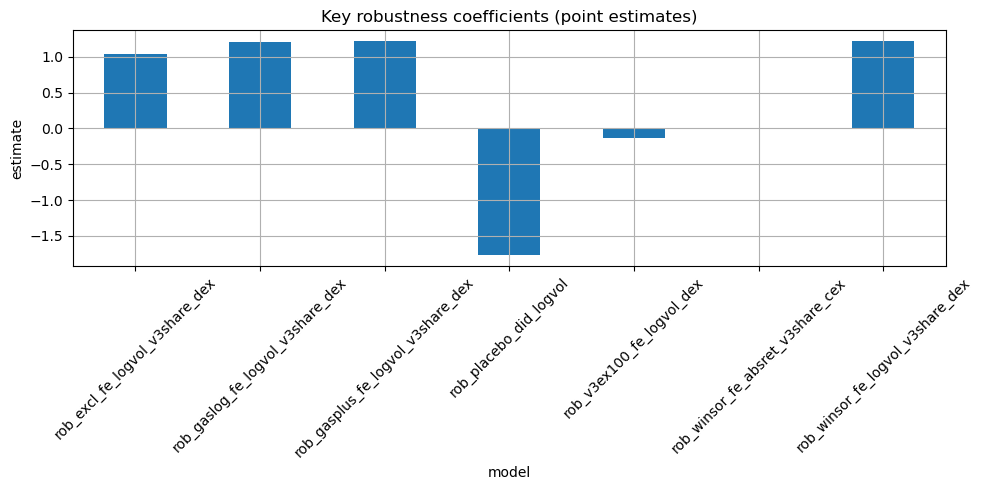

In [9]:
# =========================
# Collect key coefficients across specs and plot
# =========================
def read_key_coef(name: str, term_prefixes=('v3_share','is_dex:post','is_dex:post_fake','v3_share_excl100')):
    p = MOD_DIR / f"{name}_coefs.parquet"
    if not p.exists():
        return None
    t = pd.read_parquet(p)
    k = t.copy()
    k = k[k["term"].str.startswith(term_prefixes)]
    if k.empty:
        # try explicit interaction term label used by patsy
        k = t[t["term"].str.contains(":", regex=False)]
    if k.empty:
        return None
    # take first matching term
    row = k.iloc[0]
    return {
        "model": name,
        "term": row["term"],
        "estimate": float(row["estimate"]),
        "std_err": float(row["std_err"]),
        "p": float(row["p"]),
        "nobs": int(t["nobs"].iloc[0]) if "nobs" in t.columns else np.nan,
        "r2": float(t["r2"].iloc[0]) if "r2" in t.columns else np.nan,
    }

models_to_collect = [
    "rob_winsor_fe_logvol_v3share_dex",
    "rob_winsor_fe_absret_v3share_cex",
    "rob_gaslog_fe_logvol_v3share_dex",
    "rob_gasplus_fe_logvol_v3share_dex",
    "rob_excl_fe_logvol_v3share_dex",
    "rob_v3ex100_fe_logvol_dex",
    "rob_placebo_did_logvol",
]

rows = []
for m in models_to_collect:
    r = read_key_coef(m)
    if r:
        rows.append(r)

summary = pd.DataFrame(rows).sort_values("model")
display(summary)
summary.to_csv(TAB_DIR / "robustness_key_coefs.csv", index=False)
print(f"[OK] wrote {TAB_DIR / 'robustness_key_coefs.csv'}")

# Simple bar chart of estimates (with sign); ignore SEs for a quick visual
if not summary.empty:
    ax = summary.set_index("model")["estimate"].plot(kind="bar", rot=45)
    ax.set_title("Key robustness coefficients (point estimates)")
    ax.set_ylabel("estimate")
    savefig("robustness_key_coefs_bar")
    plt.show()

In [10]:
# =========================
# Done
# =========================
print("[Done] Robustness checks completed. Tables ->", TAB_DIR)

[Done] Robustness checks completed. Tables -> ..\reports\tables\robustness
